In [1]:
import sys
import re
import numpy as np
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, f1_score

data_name_or_path = "./datasets/pqa_labeled/pubmed_qa-train.arrow"
pubmed_qa = Dataset.from_file(data_name_or_path)
# 80% train, 20% test + validation
train_valid_test = pubmed_qa.train_test_split(test_size=0.55, shuffle=False)
# Split the 20% test + valid in half test, half valid
test_valid = train_valid_test['test'].train_test_split(test_size=0.909, shuffle=False)
# gather everyone if you want to have a single DatasetDict
train_valid_test_dataset = DatasetDict({
    'train': train_valid_test['train'],
    'valid': test_valid['train'],
    'test': test_valid['test']})

#print(train_valid_test_dataset)

label_column = "final_decision"

def preprocess_function(dataset_dict):
    # format input text according to BioGPT paper
    inputs = []
    for idx, fa in enumerate(dataset_dict[label_column]):
        inputs.append(fa)
        
    return inputs

test_sentences = preprocess_function(train_valid_test_dataset['test'])

In [2]:
def convert_relis_sentence(sentence):
    
    ans = ["maybe"]

    segs = re.search(r"the answer to the question given the context is(.*)", sentence)
    if segs is not None:
        segs = segs.groups()
        ans = segs[0].strip().lower().split()[:100]
    #print(ans)
    #return ans
    for sub_ans in ans:
        if sub_ans.find('yes') != -1:
            return "yes"
        elif sub_ans.find('no') != -1:
            return "no"
    return "maybe"

In [3]:
sum_tot_ans = []
for model_name in ['BioGPT-large-', 'BioGPT-large-lora-']:
    for alpha in [16, 32, 64, 128, 256, 512]:
        data = np.load('./trained_models/' + model_name + str(alpha) + '/BioGPT_large_results.npy')
        
        tot_ans = []
        for i, ans in enumerate(data):
            #print(i, convert_relis_sentence(ans))
            tot_ans.append(convert_relis_sentence(ans))
            
        sum_tot_ans.append(tot_ans)

In [4]:
# Sample data (true labels and predicted labels)
true_labels = test_sentences
tot_acc = []
tot_f1 = []

for tot_ans in sum_tot_ans:
    
    predicted_labels = tot_ans
    # Calculate the classification accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"accuracy: {accuracy:.3f}")
    # Calculate the classification report (includes F1-score)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"f1 score: {f1:.3f}")
    tot_acc.append(accuracy)
    tot_f1.append(f1)

accuracy: 0.310
f1 score: 0.210
accuracy: 0.248
f1 score: 0.200
accuracy: 0.256
f1 score: 0.193
accuracy: 0.430
f1 score: 0.388
accuracy: 0.286
f1 score: 0.242
accuracy: 0.326
f1 score: 0.291
accuracy: 0.406
f1 score: 0.282
accuracy: 0.510
f1 score: 0.334
accuracy: 0.550
f1 score: 0.332
accuracy: 0.552
f1 score: 0.291
accuracy: 0.638
f1 score: 0.391
accuracy: 0.608
f1 score: 0.393


In [5]:
import matplotlib.pyplot as plt

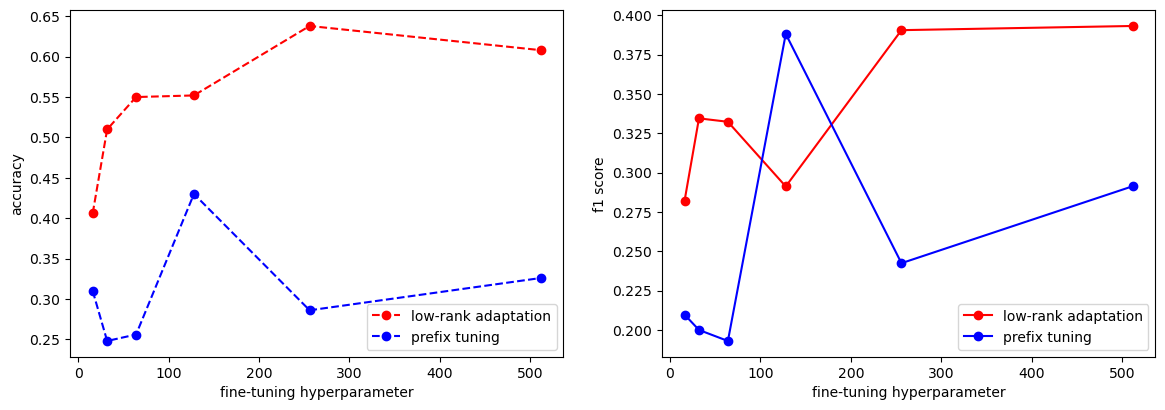

In [6]:
x = [16, 32, 64, 128, 256, 512]
y1 = tot_acc[:6]
y2 = tot_acc[-6:]

z1 = tot_f1[:6]
z2 = tot_f1[-6:]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4.5))

# Plot the first subplot
ax1.plot(x, y2, color='red', linestyle='dashed', marker='o', label='low-rank adaptation')
ax1.plot(x, y1, color='blue', linestyle='dashed', marker='o', label='prefix tuning')

#ax1.set_title('Plot 1')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('fine-tuning hyperparameter')
ax1.legend(loc='lower right')

# Plot the second subplot
ax2.plot(x, z2, color='red', linestyle='solid', marker='o', label='low-rank adaptation')
ax2.plot(x, z1, color='blue', linestyle='solid', marker='o', label='prefix tuning')

#ax2.set_title('Plot 2')
ax2.set_ylabel('f1 score')
ax2.set_xlabel('fine-tuning hyperparameter')
ax2.legend(loc='lower right')

# Display the figure
plt.savefig('line_plot.png')
plt.show()

In [7]:
sum_tot_ans = []
for model_name in ['llama-7b-none-lora-', 'alpaca-7b-instru-lora-']:
    for alpha in [32, 64, 128, 256]:
        data = np.load('./trained_models/' + model_name + str(alpha) + '/' + model_name.split('-', 1)[0] +'_results.npy')
        
        tot_ans = []
        for i, ans in enumerate(data):
            #print(i, convert_relis_sentence(ans))
            tot_ans.append(convert_relis_sentence(ans))
            
        sum_tot_ans.append(tot_ans)

In [8]:
# Sample data (true labels and predicted labels)
true_labels = test_sentences

for tot_ans in sum_tot_ans:
    
    predicted_labels = tot_ans
    # Calculate the classification accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"accuracy: {accuracy:.3f}")
    # Calculate the classification report (includes F1-score)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"f1 score: {f1:.3f}")

accuracy: 0.584
f1 score: 0.449
accuracy: 0.490
f1 score: 0.430
accuracy: 0.600
f1 score: 0.453
accuracy: 0.594
f1 score: 0.495
accuracy: 0.340
f1 score: 0.318
accuracy: 0.380
f1 score: 0.335
accuracy: 0.190
f1 score: 0.195
accuracy: 0.292
f1 score: 0.275


In [9]:
sum_tot_ans = []
for model_name in ['llama-7b-none-lora-', 'llama-7b-rewriteQA-lora-', 'llama-7b-newQA-lora-', 'llama-7b-combinedQA-lora-']:
    for alpha in [32, 64, 128, 256]:
        data = np.load('./trained_models/' + model_name + str(alpha) + '/' + model_name.split('-', 1)[0] +'_results.npy')
        
        tot_ans = []
        for i, ans in enumerate(data):
            #print(i, convert_relis_sentence(ans))
            tot_ans.append(convert_relis_sentence(ans))
            
        sum_tot_ans.append(tot_ans)

In [10]:
# Sample data (true labels and predicted labels)
true_labels = test_sentences

for tot_ans in sum_tot_ans:
    
    predicted_labels = tot_ans
    # Calculate the classification accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"accuracy: {accuracy:.3f}")
    # Calculate the classification report (includes F1-score)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"f1 score: {f1:.3f}")

accuracy: 0.584
f1 score: 0.449
accuracy: 0.490
f1 score: 0.430
accuracy: 0.600
f1 score: 0.453
accuracy: 0.594
f1 score: 0.495
accuracy: 0.638
f1 score: 0.498
accuracy: 0.642
f1 score: 0.497
accuracy: 0.610
f1 score: 0.484
accuracy: 0.542
f1 score: 0.423
accuracy: 0.504
f1 score: 0.433
accuracy: 0.524
f1 score: 0.443
accuracy: 0.552
f1 score: 0.460
accuracy: 0.550
f1 score: 0.439
accuracy: 0.582
f1 score: 0.485
accuracy: 0.616
f1 score: 0.467
accuracy: 0.594
f1 score: 0.460
accuracy: 0.544
f1 score: 0.434


In [11]:
sum_tot_ans = []
for model_name in ['llama-7b-rewrite4QA-lora-', 'llama-7b-new4QA-lora-', 'llama-7b-combined4QA-lora-', 'llama-7b-combined3+4QA-lora-']:
    for alpha in [32, 64, 128, 256]:
        data = np.load('./trained_models/' + model_name + str(alpha) + '/' + model_name.split('-', 1)[0] +'_results.npy')
        
        tot_ans = []
        for i, ans in enumerate(data):
            
            tot_ans.append(convert_relis_sentence(ans))
            #print(i, tot_ans[i])
            
        sum_tot_ans.append(tot_ans)

In [12]:
# Sample data (true labels and predicted labels)
true_labels = test_sentences

for tot_ans in sum_tot_ans:
    
    predicted_labels = tot_ans
    # Calculate the classification accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"accuracy: {accuracy:.3f}")
    # Calculate the classification report (includes F1-score)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"f1 score: {f1:.3f}")

accuracy: 0.378
f1 score: 0.363
accuracy: 0.442
f1 score: 0.391
accuracy: 0.466
f1 score: 0.404
accuracy: 0.540
f1 score: 0.463
accuracy: 0.488
f1 score: 0.430
accuracy: 0.504
f1 score: 0.434
accuracy: 0.490
f1 score: 0.422
accuracy: 0.576
f1 score: 0.451
accuracy: 0.468
f1 score: 0.405
accuracy: 0.446
f1 score: 0.401
accuracy: 0.554
f1 score: 0.433
accuracy: 0.506
f1 score: 0.446
accuracy: 0.482
f1 score: 0.413
accuracy: 0.558
f1 score: 0.438
accuracy: 0.498
f1 score: 0.403
accuracy: 0.556
f1 score: 0.458


In [13]:
sum_tot_ans = []
for model_name in ['alpaca-7b-instru-lora-', 'alpaca-7b-instru-rewriteQA-lora-', 'alpaca-7b-instru-newQA-lora-', 'alpaca-7b-instru-combinedQA-lora-']:
    for alpha in [32, 64, 128, 256]:
        data = np.load('./trained_models/' + model_name + str(alpha) + '/' + model_name.split('-', 1)[0] +'_results.npy')
        
        tot_ans = []
        for i, ans in enumerate(data):
            #print(i, ans, convert_relis_sentence(ans))
            tot_ans.append(convert_relis_sentence(ans))
            
        sum_tot_ans.append(tot_ans)

In [14]:
# Sample data (true labels and predicted labels)
true_labels = test_sentences

for tot_ans in sum_tot_ans:
    
    predicted_labels = tot_ans
    # Calculate the classification accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"accuracy: {accuracy:.3f}")
    # Calculate the classification report (includes F1-score)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"f1 score: {f1:.3f}")

accuracy: 0.340
f1 score: 0.318
accuracy: 0.380
f1 score: 0.335
accuracy: 0.190
f1 score: 0.195
accuracy: 0.292
f1 score: 0.275
accuracy: 0.544
f1 score: 0.454
accuracy: 0.320
f1 score: 0.317
accuracy: 0.342
f1 score: 0.325
accuracy: 0.352
f1 score: 0.316
accuracy: 0.232
f1 score: 0.210
accuracy: 0.334
f1 score: 0.305
accuracy: 0.356
f1 score: 0.338
accuracy: 0.378
f1 score: 0.353
accuracy: 0.348
f1 score: 0.310
accuracy: 0.542
f1 score: 0.442
accuracy: 0.464
f1 score: 0.412
accuracy: 0.328
f1 score: 0.321


In [15]:
sum_tot_ans = []
for model_name in ['BioGPT-large-rewriteQA-lora-', 'BioGPT-large-newQA-lora-', 'BioGPT-large-combinedQA-lora-', 'BioGPT-large-combined3and4QA-lora-']:
    for alpha in [32, 64, 128, 256]:
        data = np.load('./trained_models/' + model_name + str(alpha) + '/' + model_name.split('-', 1)[0] +'_large_results.npy')
        
        tot_ans = []
        for i, ans in enumerate(data):
            #print(i, ans, convert_relis_sentence(ans))
            tot_ans.append(convert_relis_sentence(ans))
            
        sum_tot_ans.append(tot_ans)

In [16]:
# Sample data (true labels and predicted labels)
true_labels = test_sentences

for tot_ans in sum_tot_ans:
    
    predicted_labels = tot_ans
    # Calculate the classification accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"accuracy: {accuracy:.3f}")
    # Calculate the classification report (includes F1-score)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"f1 score: {f1:.3f}")

accuracy: 0.648
f1 score: 0.442
accuracy: 0.698
f1 score: 0.497
accuracy: 0.720
f1 score: 0.498
accuracy: 0.704
f1 score: 0.490
accuracy: 0.562
f1 score: 0.378
accuracy: 0.682
f1 score: 0.463
accuracy: 0.708
f1 score: 0.485
accuracy: 0.718
f1 score: 0.491
accuracy: 0.664
f1 score: 0.459
accuracy: 0.714
f1 score: 0.493
accuracy: 0.710
f1 score: 0.482
accuracy: 0.708
f1 score: 0.489
accuracy: 0.646
f1 score: 0.470
accuracy: 0.658
f1 score: 0.473
accuracy: 0.668
f1 score: 0.476
accuracy: 0.710
f1 score: 0.490


In [17]:
sum_tot_ans = []
for model_name in ['BioGPT-large-rewrite4QA-lora-', 'BioGPT-large-new4QA-lora-', 'BioGPT-large-combined4QA-lora-', 'BioGPT-large-combined3+4QA-lora-']:
    for alpha in [32, 64, 128, 256]:
        data = np.load('./trained_models/' + model_name + str(alpha) + '/' + model_name.split('-', 1)[0] +'_large_results.npy')
        
        tot_ans = []
        for i, ans in enumerate(data):
            #print(i, ans, convert_relis_sentence(ans))
            tot_ans.append(convert_relis_sentence(ans))
            
        sum_tot_ans.append(tot_ans)

In [18]:
# Sample data (true labels and predicted labels)
true_labels = test_sentences

for tot_ans in sum_tot_ans:
    
    predicted_labels = tot_ans
    # Calculate the classification accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"accuracy: {accuracy:.3f}")
    # Calculate the classification report (includes F1-score)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"f1 score: {f1:.3f}")

accuracy: 0.572
f1 score: 0.452
accuracy: 0.480
f1 score: 0.389
accuracy: 0.654
f1 score: 0.471
accuracy: 0.580
f1 score: 0.471
accuracy: 0.586
f1 score: 0.323
accuracy: 0.674
f1 score: 0.462
accuracy: 0.718
f1 score: 0.492
accuracy: 0.754
f1 score: 0.520
accuracy: 0.602
f1 score: 0.470
accuracy: 0.660
f1 score: 0.511
accuracy: 0.724
f1 score: 0.512
accuracy: 0.708
f1 score: 0.518
accuracy: 0.708
f1 score: 0.489
accuracy: 0.702
f1 score: 0.506
accuracy: 0.722
f1 score: 0.494
accuracy: 0.730
f1 score: 0.502


In [19]:
def convert_relis_sentence(sentence, GPT=False):
    
    if not GPT:
        ans = ["maybe"]
        segs = re.search(r"the answer to the question given the context is(.*)", sentence)
        if segs is not None:
            segs = segs.groups()
            ans = segs[0].strip().lower().split()[:10]
    else:
        ans = sentence.strip().lower().split()[:10]
    #return ans
    for sub_ans in ans:
        if sub_ans.lower().find('yes') != -1:
            return "yes"
        elif sub_ans.lower().find('no') != -1:
            return "no"
        else:
            return "maybe"

In [20]:
sum_tot_ans = []
data = np.load('gpt3.5_answer_49.npy')

tot_ans = []
for i, ans in enumerate(data):
    #print(i, ans, convert_relis_sentence(ans, True))
    tot_ans.append(convert_relis_sentence(ans, True))

sum_tot_ans.append(tot_ans)

In [21]:
# Sample data (true labels and predicted labels)
true_labels = test_sentences

for tot_ans in sum_tot_ans:
    
    predicted_labels = tot_ans
    # Calculate the classification accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"accuracy: {accuracy:.3f}")
    # Calculate the classification report (includes F1-score)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"f1 score: {f1:.3f}")

accuracy: 0.372
f1 score: 0.327
